In [1]:
import numpy as np 
import pandas as pd 
from scipy.stats import zscore 
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
# import and data cleanup
df1 = pd.read_csv("/raters/maisie.csv")
df1.group_id = "rater1"

df2 = pd.read_csv("/raters/romi.csv")
df2.group_id = "rater2"

df3 = pd.read_csv("/raters/ema.csv")
df3.group_id = "rater3"

df4 = pd.read_csv("/rater1/fundo.csv") 
df4.group_id = "rater4"

df5 = pd.read_csv("/rater5/STEPH.csv")
df5.group_id = "rater5"
df5 = df5[["group_id","response_name","response_value","trial_template"]]


# concatenate data from 5 rates
Dataset = pd.concat([df1,df2,df3,df4,df5,])
Dataset = Dataset[["group_id","response_name","response_value","trial_template"]].dropna() # 2 trial_templates on "closeness" couldn't be merged, but here we only look at the rating scores for texts. Have to come back to original df later
Dataset = Dataset.rename(columns={"group_id": "raters"}) 

# separate dataframe for human-rated sarcasm score and closesness level.
Data = Dataset[Dataset.response_name == "a_sarcasm"]
Data_close = Dataset[Dataset.trial_template == "closeness_2"]

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_32/2806611729.py:2: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


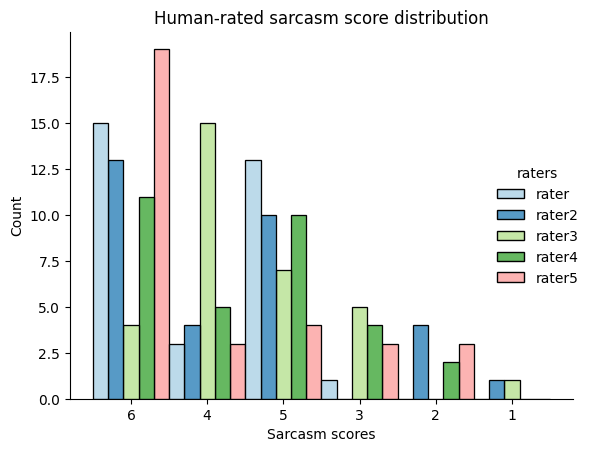

In [22]:
# Plotting sarcasm score distribution

sns.displot(Data, x="response_value", hue="raters", multiple="dodge", palette="Paired").set(xlabel="Sarcasm scores", title="Human-rated sarcasm score distribution")
plt.tight_layout()
plt.subplots_adjust(top=0.85)

plt.savefig("human_sarcasm.png")

/tmp/ipykernel_32/1004397873.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data.response_value = Data.response_value.astype(float)


raters
rater     5.31250
rater2    4.78125
rater3    4.21875
rater4    4.75000
rater5    5.03125
Name: response_value, dtype: float64 raters
rater     0.780302
rater2    1.475267
rater3    1.069651
rater4    1.244342
rater5    1.402403
Name: response_value, dtype: float64


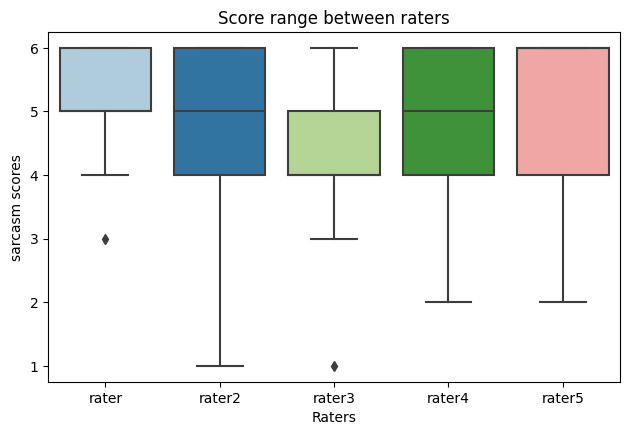

In [45]:
Data.response_value = Data.response_value.astype(float)
sarc_mean = Data.groupby(['raters']).response_value.mean()
sarc_std = Data.groupby(['raters']).response_value.std()
print(sarc_mean,sarc_std)

sns.boxplot(data=Data, x="raters", y="response_value", palette="Paired").set(xlabel="Raters", ylabel= "sarcasm scores", title="Score range between raters")
plt.tight_layout()
plt.subplots_adjust(top=0.85)

plt.savefig("raters_range.png")

In [16]:
rater3 = Data[Data["raters"] == "rater3"]
rater1 = Data[Data["raters"] == "rater"]
rater5 = Data[Data["raters"] == "rater5"]
rater2 = Data[Data["raters"] == "rater2"]

In [18]:
# paired samples T test between raters

stats.ttest_rel(rater3.response_value, rater5.response_value)  # mean of rater 3 & 5 significantly different 

TtestResult(statistic=-2.5230408469605377, pvalue=0.016978378732155346, df=31)

### Standardize the score among raters

In [8]:
z_sarc = Data.groupby(['raters']).response_value.agg({'mean','std'}).reset_index()
df_sarc = pd.merge(Data, z_sarc, how='left', on=['raters'])

In [41]:
# calculating the proportion of ratings above 4, and the sarcasm mean & std 

total = len(Data.response_value) # total ratings (32*5)
count = len(Data[Data["response_value"] == 6]) + len(Data[Data["response_value"] ==5]) + len(Data[Data["response_value"] == 4])
Mean_human = Data.response_value.mean()
std_human = Data.response_value.std()
print(count, count/total, round(Mean_human,2), round(std_human,2))

136 0.85 4.82 1.26


In [9]:
df_sarc["z_scored"] = ((df_sarc["response_value"].to_numpy() - df_sarc["mean"].to_numpy()) / df_sarc["std"].to_numpy()).tolist()
df_sarc

,raters,response_name,response_value,trial_template,mean,std,z_scored
0,rater,a_sarcasm,6.0,4n,5.31250,0.780302,0.881069
1,rater,a_sarcasm,6.0,18n,5.31250,0.780302,0.881069
2,rater,a_sarcasm,6.0,23n,5.31250,0.780302,0.881069
3,rater,a_sarcasm,6.0,6n,5.31250,0.780302,0.881069
4,rater,a_sarcasm,6.0,16n,5.31250,0.780302,0.881069
...,...,...,...,...,...,...,...
155,rater5,a_sarcasm,3.0,17n,5.03125,1.402403,-1.448407
156,rater5,a_sarcasm,6.0,3n,5.03125,1.402403,0.690779
157,rater5,a_sarcasm,4.0,27n,5.03125,1.402403,-0.735345
158,rater5,a_sarcasm,5.0,31n,5.03125,1.402403,-0.022283


In [10]:
# groupby trial_template with mean of z score so we obtain one rating for each stimulus

sarc_score = df_sarc.groupby(['trial_template']).z_scored.agg('mean')

In [11]:
sarc_score = sarc_score.reset_index()
data_lex = pd.read_csv("data_lex.csv")
df_lex = pd.merge(data_lex, sarc_score, how="left",left_on="trial_id", right_on="trial_template")

In [12]:
df_lex = df_lex.rename(columns={"z_scored": "sarcasm"})
df_lex.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         32 non-null     int64  
 1   name               32 non-null     object 
 2   prompts            32 non-null     object 
 3   responses          32 non-null     object 
 4   trial_id           32 non-null     object 
 5   polarity_p         32 non-null     float64
 6   subjectivity_p     32 non-null     float64
 7   polarity_r         32 non-null     float64
 8   subjectivity_r     32 non-null     float64
 9   WC_p               32 non-null     int64  
 10  Concreteness_P     32 non-null     float64
 11  Brysbaert_P        32 non-null     float64
 12  Familiarity_P      32 non-null     float64
 13  Imageability_P     32 non-null     float64
 14  Meaningfulness_P   32 non-null     float64
 15  WC_r               32 non-null     int64  
 16  Concreteness_R     32 non-nu

In [14]:
df_lex.to_csv('dataset.csv')

### humans vs. machine

In [15]:
# import the entire dataset
df = pd.read_csv("dataset.csv")

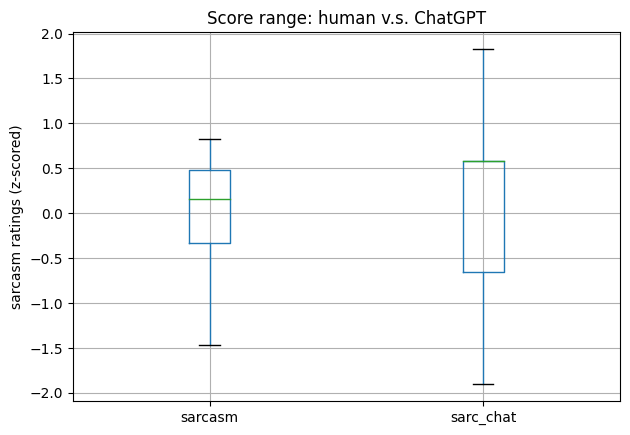

In [16]:
df.boxplot(column = ['sarcasm','sarc_chat']).set(ylabel= "sarcasm ratings (z-scored)", title="Score range: human v.s. ChatGPT")
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.savefig("range_comparison.png")

/tmp/ipykernel_32/3401411580.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.delta = df.sarcasm - df.sarc_chat
/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


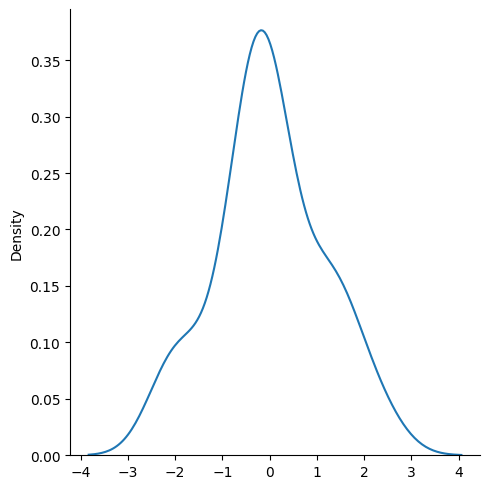

In [17]:
# plotting delta
df.delta = df.sarcasm - df.sarc_chat

sns.displot(x = df.delta, kind="kde")
plt.savefig("delta.png")

In [55]:
print(round(df.delta.mean(),2), round(df.delta.std(),2))

-0.0 1.13


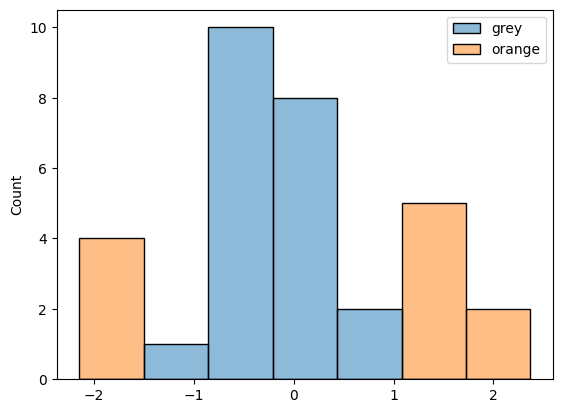

In [18]:
max_del = df.delta.mean() + df.delta.std()
min_del = df.delta.mean() - df.delta.std()

cols = ['grey' if (x < max_del and x > min_del) else 'orange' for x in df.delta]
sns.histplot(x = df.delta, hue=cols)
plt.savefig("delta.png")

### Extract closeness mark and sarcasm mean

In [1]:
closeness = Dataset[Dataset.trial_template == "closeness_2"]
closeness

,raters,response_name,response_value,trial_template
82,rater,a_close,not so much,closeness_2
82,rater2,a_close,somewhat,closeness_2
82,rater3,a_close,mostly,closeness_2
82,rater4,a_close,somewhat,closeness_2
82,rater5,a_close,mostly not,closeness_2


In [5]:
df_close = pd.merge(closeness, sarc_mean, how='left', on=['raters'])
df_close = df_close.rename(columns = {'response_value_y':'sarc_mean', "response_value_x":'closeness'})
df_close

,raters,response_name,closeness,trial_template,sarc_mean
0,rater,a_close,not so much,closeness_2,5.31250
1,rater2,a_close,somewhat,closeness_2,4.78125
2,rater3,a_close,mostly,closeness_2,4.21875
3,rater4,a_close,somewhat,closeness_2,4.75000
4,rater5,a_close,mostly not,closeness_2,5.03125
